In [1]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
from train_utils import sparse_data_generator_from_hdf5_spikes
from train_utils import get_train_test_data
import torch
from utils import get_device

time_steps = 100
num_inputs = 700
num_hidden = 1000
num_outputs = 20

max_time = 1.4
beta = 0.99
device = get_device()
dtype = torch.float


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(time_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
net = Net().to(device)


In [3]:
x_train, y_train, x_test, y_test = get_train_test_data()    

data_generator = list(sparse_data_generator_from_hdf5_spikes(x_train, y_train,
                                    batch_size=128,
                                    nb_steps=time_steps,
                                    nb_units=num_inputs,
                                    max_time=max_time,
                                    device=device))

/home/mark/Dokumente/whk-snn/whk-snn/heidelberg_implementation/train_utils.py:54: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1744247799952/work/torch/csrc/utils/tensor_new.cpp:644.)
  X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)


In [4]:
len(data_generator)

63

In [21]:
data, target = data_generator[0]

data = data.to_dense().permute(1, 0, 2)

data = data.to(device)
targets = target.to(device)

spk_rec, mem_rec = net(data)

In [22]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss = nn.CrossEntropyLoss()
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(time_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 311.066


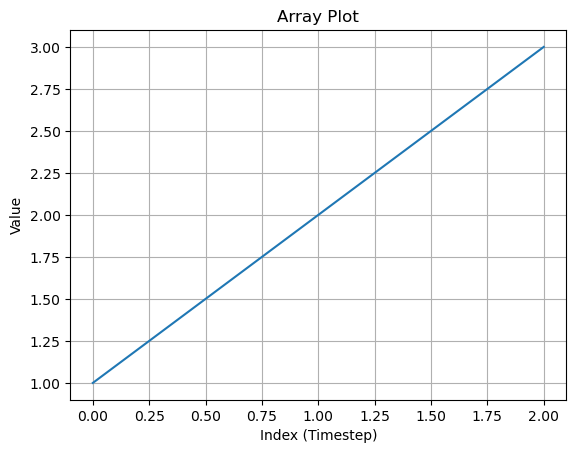

In [6]:
import numpy as np
import matplotlib.pyplot as plt

loss_hist = [1,2,3]

plt.figure()
plt.plot(loss_hist)
plt.xlabel("Index (Timestep)")
plt.ylabel("Value")
plt.title("Array Plot")
plt.grid(True)

#plt.show()
plt.savefig("./simplified_loss_hist2.png")
#plt.close()

In [25]:
print_batch_accuracy(data, target, batch_size=128)

Test set accuracy for a single minibatch: 15.62%


In [16]:
optimizer.zero_grad()
loss_val.backward()
optimizer.step()

In [24]:
import numpy as np

def print_batch_accuracy(data, targets, batch_size, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

In [ ]:


optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 30

loss_hist = []
acc_hist = []

print("start of training loop")
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(data_generator):
        data = data.to_dense().permute(1, 0, 2)
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = net.forward(data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")